# Классификация изображений с использованием tf.keras

В этом CoLab вы будете классифицировать изображения цветов. Вы будете разрабатывать классификатор изображений с использованием `tf.keras.Sequential`, а данные загружать с использованием `ImageDataGenerator`.

# Импортирование пакетов

Давайте начнем с импортирования необходимых пакетов. `os` пакет нужен нам для чтения файлов и структуры директорий, `numpy` нужен нам для преобразования python-списков в numpy-массивы для выполнения матричных операций и, в завершение, нам понадобится `matplotlib.pyplot` для отрисовки графиков и отображения исходных и преобразованных изображений.

In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import glob
import os
import shutil

import matplotlib.pyplot as plt

### TODO: импортируем TensorFlow и Keras-слои

В приведённой ниже области для исходного кода импортируйте TensorFlow как `tf` и Keras-слои с моделями, которые вы будете использовать для построения свёрточной нейронной сети. Так же, импортируйте `ImageDataGenerator`-класс из Keras для работы с изображениями и расширения исходного набора данных.

In [28]:
# импорт пакетов
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Загрузка данных

Начать разработку нашего классификатора изображений нужно с загрузки набора данных с которым мы будем работать - цветочный набор данных. Первым делом необходимо загрузить архив с набором данных и сохранить его во временной директории.

Загруженный архив необходимо разархивировать.

In [7]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228813984/228813984 [==============================] - 21s 0us/step


Набор данных, который мы загрузили архивом, содержит 5 типов цветов:
1. Розы
2. Маргаритки
3. Одуванчики
4. Подсолнухи
5. Тюльпаны

Создадим метки для каждого из этих пяти классов:

In [8]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Набор данных, который мы загрузили, имеет следующую структуру:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Как вы уже обратили внимание в структуре загруженного набора данных отсутствуют директории с обучающим набором данных и валидационным. Таким образом создание этих двух наборов данных будет лежать на наших плечах. Давайте напишем код, который будет это делать.

Код ниже создаёт 2 директории `train` и `val` в каждой из которых будет 5 под-директорий (одна на каждый тип изображения). После этого мы переместим изображения в эти директории таким образом, чтобы 80% изображений попадало в обучающий набор данных, а остальные 20% попадали в валидационный набор данных. Итоговая структура будет выглядеть следующим образом:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]   
</pre>

Так как мы не удаляем исходные директории, то они останутся у нас, но будут пустыми. Код ниже так же выведет на экран количество изображений по каждому типу цветка.

In [9]:
for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} изображений".format(cl, len(images)))
    train, val = images[:round(len(images) * 0.8)], images[round(len(images) * 0.8):]

    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 изображений
daisy: 633 изображений
dandelion: 898 изображений
sunflowers: 699 изображений
tulips: 799 изображений


Для удобства вынесем ссылки на директории каждого набора данных в отдельные переменные:

In [10]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


# Расширение данных

Переобучение, в основном, происходит тогда, когда у нас маленький обучающий набор данных. Один из способов устранить эту проблему - расширение данных (т.н. augmentation) до нужного количества обучающих примеров. Расширение данных представляет собой процесс применения произвольных трансформации к исходным данным и добавление полученных изменённых данных в первоначальный обучающий набор. Цель заключается в том, чтобы сгенерировать реалистичные изображения, которые модель больше никогда не увидит в последующем - ни в валидационном наборе данных, ни в тестовом. Такой подход позволяет модели лучше обобщать и извлекать различные признаки.

В **tf.keras** мы можем это реализовать с использованием класса, который раньше нами применялся для генерации обучающего набора данных кошек и собак - **ImageDataGenerator**. Мы просто передаём конструктору класса набор различных значений нужных нам параметров и обо всём остальном он позаботится сам. 

## Экспериментируйте с различными преобразованиями изображений

В этой части вы получите практический опыт применения некоторых базовых преобразования изображений. Перед тем как мы будем применять преобразования давайте объявим две переменные - одна будет содержать значение количества обучающих блоков (изображений) за одну итерацию `batch_size`, а вторая размеры нашего изображения на входе в свёрточную нейронную сеть `IMG_SHAPE`.

#### TODO: установите количество обучающих блоков и размер изображений

В ячейке ниже укажите значение 100 для переменной `batch_size` и значение 150 для переменной `IMG_SHAPE`:

In [11]:
batch_size = 100
IMG_SHAPE = 150

#### TODO: примените произвольный горизонтальный переворот изображения

В ячейке ниже воспользуйтесь классом `ImageDataGenerator` для создания преобразования, которое сперва нормализует значения пикселей цветных изображений, а затем применит произвольный горизонтальный переворот. После этого воспользуйтесь методом `.flow_from_directory` для применения полученного преобразования к изображениям из обучающего набора данных. Убедитесь, что указали корректно размер обучающего блока, путь к директории с обучающим набором данных, целевой размер изображений и не забудьте затем перемешать все изображения.

In [12]:

image_gen = ImageDataGenerator(
    rescale=1. / 255,  # нормализация значений пикселей
    horizontal_flip=True  # горизонтальный переворот
)

# Применение преобразования к изображениям из обучающего набора данных
train_data_gen = image_gen.flow_from_directory(
    train_dir,  # путь к директории с обучающим набором данных
    target_size=(IMG_SHAPE, IMG_SHAPE),  # целевой размер изображений
    batch_size=batch_size,  # размер обучающего блока
    class_mode='sparse',
    shuffle=True  # перемешивание изображений

)

Found 2935 images belonging to 5 classes.


Давайте возьмём одно произвольное изображение и отобразим его 5 раз применив случайным образом наше преобразование:

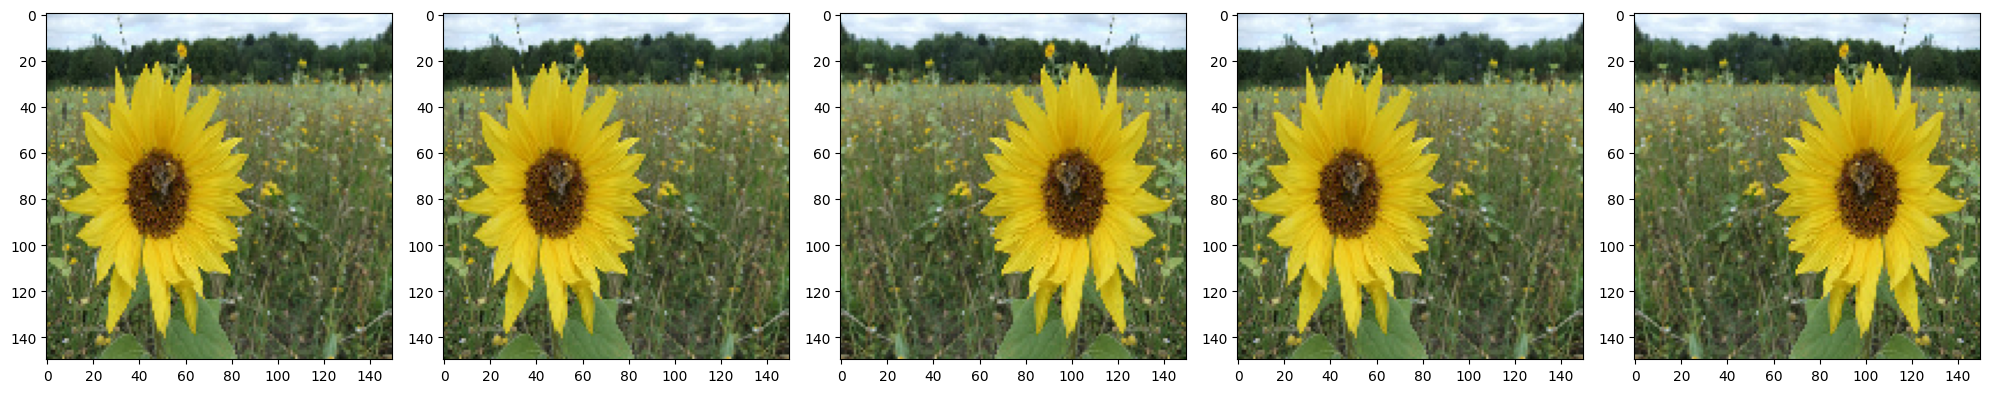

In [13]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()
  
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### TODO: примените произвольный переворот изображения

В ячейке ниже, воспользовавшись классом `ImageDataGenerator` сперва нормализуйте цветное изображение и примените произвольный поворот на 25 градусов. После этого воспользуйтесь методом .flow_from_directory для применения полученного преобразования к изображениям из обучающего набора данных. Убедитесь, что указали корректно размер обучающего блока, путь к директории с обучающим набором данных, целевой размер изображений и не забудьте затем перемешать все изображения.

In [14]:
image_gen = ImageDataGenerator(
    rescale=1. / 255,  # нормализация значений пикселей
    rotation_range=25  # поворот на 25 градусов
)

# Применение преобразования к изображениям из обучающего набора данных
train_data_gen = image_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),  # целевой размер изображений
    batch_size=batch_size,  # размер обучающего блока
    class_mode='sparse',
    shuffle=True  # перемешивание изображений

)

Found 2935 images belonging to 5 classes.


Давайте возьмём одно произвольное изображение и отобразим его 5 раз применив случайным образом наше преобразование:

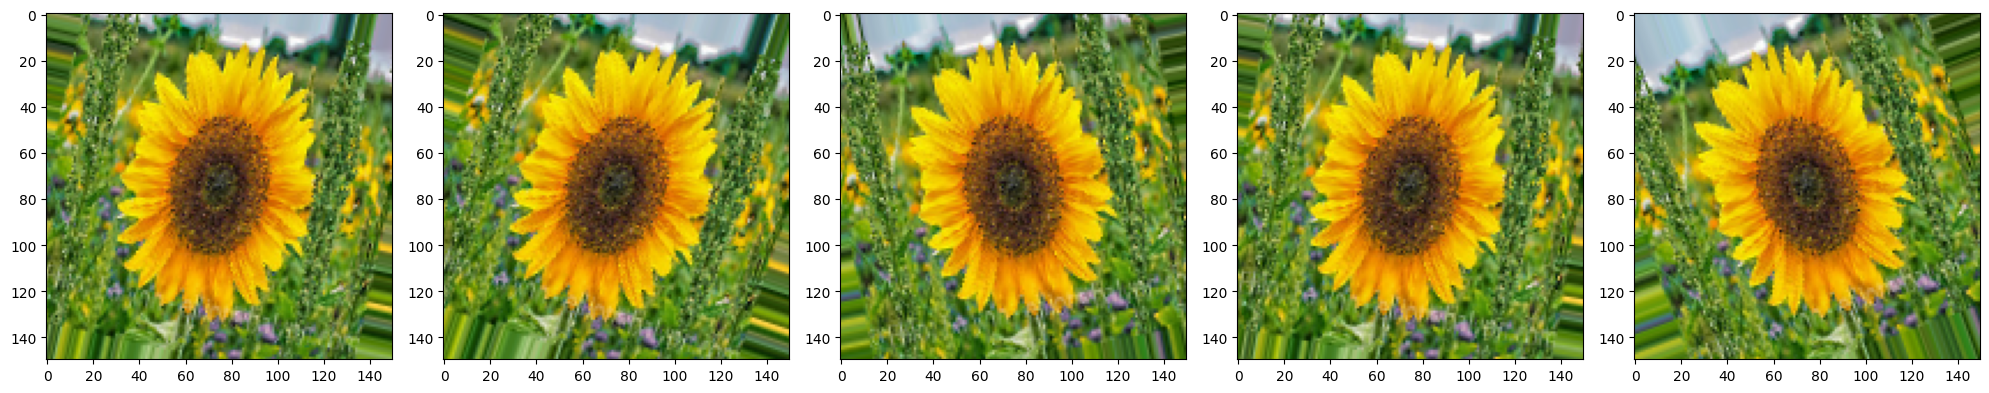

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### TODO: примените произвольное увеличение изображения

В ячейке ниже, воспользовавшись классом ImageDataGenerator сперва нормализуйте цветное изображение и примените произвольное увеличение до 30%. После этого воспользуйтесь методом .flow_from_directory для применения полученного преобразования к изображениям из обучающего набора данных. Убедитесь, что указали корректно размер обучающего блока, путь к директории с обучающим набором данных, целевой размер изображений и не забудьте затем перемешать все изображения.

In [16]:
image_gen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.3,  # Увеличение изображения до 30%
)

# Применяем метод flow_from_directory для чтения данных из директории
train_data_gen = image_gen.flow_from_directory(
    train_dir,
    batch_size=batch_size,  # Размер блока данных
    shuffle=True,  # Перемешиваем все изображения
    target_size=(IMG_SHAPE, IMG_SHAPE),  # Целевой размер изображений
    class_mode='sparse'
)

Found 2935 images belonging to 5 classes.


Давайте возьмём одно произвольное изображение и отобразим его 5 раз применив случайным образом наше преобразование:

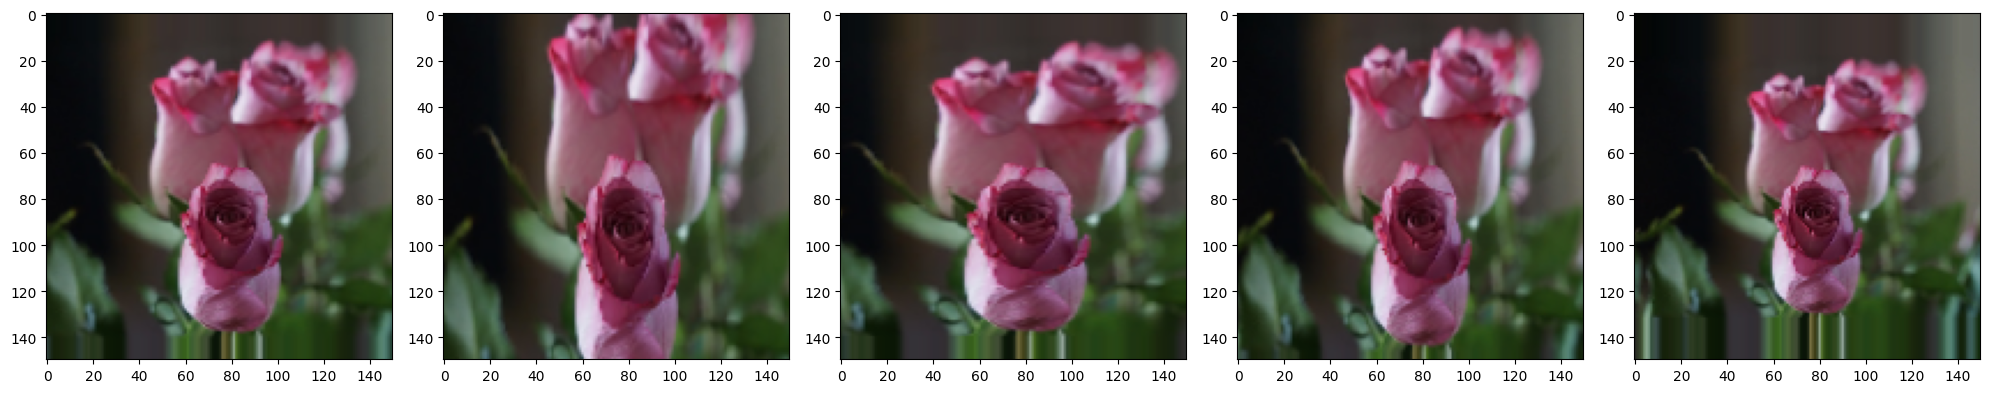

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### TODO: объединяем все изменения

В ячейке ниже укажите код, который использует `ImageDataGenerator` для нормализации цветного изображения и выполняет следующие преобразования произвольным образом:

- поворот на 25 градусов
- увеличение до 30%
- горизонтальное отражение 
- смещение по ширине на 0.1
- смещение по высоте на 0.1

Затем воспользуйтесь методом `flow_from_directory` для применения перечисленных выше трансформаций к изображениям в обучающем наборе. Убедитесь, что указали корректно размер обучающего блока, путь к директории с обучающим набором данных, целевой размер изображений и не забудьте затем перемешать все изображения.

In [18]:
image_gen_train = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

train_data_gen = image_gen_train.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse',
    target_size=(IMG_SHAPE, IMG_SHAPE)
)

Found 2935 images belonging to 5 classes.


Давайте возьмём одно произвольное изображение и отобразим его 5 раз применив случайным образом наши преобразования:

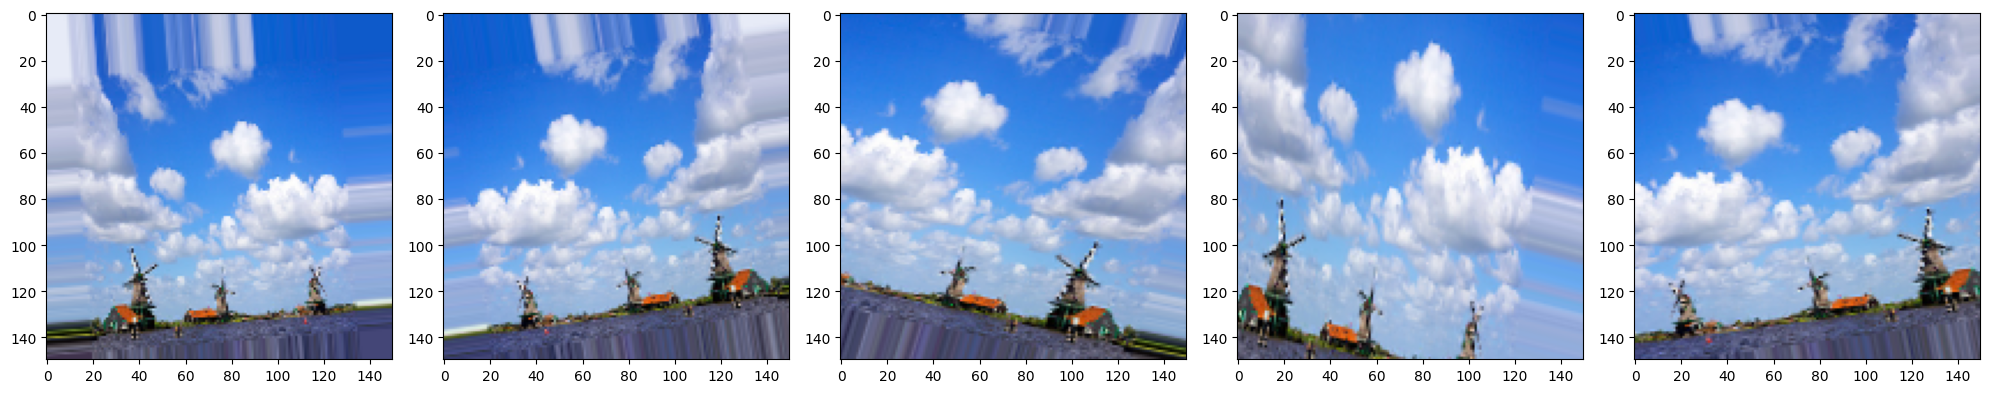

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### TODO: создайте генератор изображений для валидационного набора данных

В основном расширение данных применяется к обучающему набору данных. Поэтому, в ячейке ниже, воспользуйтесь классом `ImageDataGenerator` только для того, чтобы нормализовать значения пикселей цветного изображения. Затем воспользуйтесь методом `flow_from_directory` для применения указанной единственной трансформации к изображениям в валидационном наборе. Убедитесь, что указали корректно размер валидационного блока, путь к директории с валидационным набором данных и целевой размер изображений. Перемешивать валидационный набор данных не обязательно.

In [20]:
image_gen_val = ImageDataGenerator(rescale=1. / 255)

val_data_gen = image_gen_val.flow_from_directory(
    directory=val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size = batch_size,
    class_mode="sparse"
)

Found 735 images belonging to 5 classes.


# TODO: Создайте свёрточную нейронную сеть

В ячейке ниже создайте свёрточную нейронную сеть, которая будет состоять из 3 свёрточных пар - слой свёртки и слой подвыборки по максимальному значению. Первый свёрточный слой должен иметь 16 фильтров, второй - 32 фильтра, третий - 64 фильтра. Все фильтры должны быть размером 3х3. Размер окна подвыборки на всех слоях должен быть размером 3х3.

После всех трёх свёрточных пар должен идти слой `Flatten`, а затем полносвязный слой с 256 нейронами. Свёрточная нейронная сеть на выходе должна выдавать распределение вероятностей по 5 классам, чего можно добиться использованием функции активации **softmax**. Все остальные слои должны использовать функцию активации **relu**. Так же, где имеет смысл, добавьте слой отключения нейронов с вероятностью 20%.

In [21]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0

# TODO: скомпилируйте модель

В ячейке ниже напишите код, который будет компилировать модель с использованием оптимизатора `adam` и использовать `sparse_categorical_crossentropy` в качестве функции потерь. Так же мы хотим отслеживать метрику точности на обучающем наборе данных и валидационном наборе на каждой обучающей итерации, поэтому не забудьте передать соответствующий параметр в метод `compile(...)`.

In [22]:
# компилирование модели
from tensorflow.keras.optimizers import Adam

model1.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TODO: обучите модель

В ячейке ниже напишите код, который запустит обучение модели с использованием функции **fit_generator** вместо обычной функции **fit**, которую мы ранее использовали. Мы используем функцию **fit_generator** потому что прибегаем к использованию класса **ImageDataGenerator** для генерации новых обучающих и валидационных данных для нашей модели. Обучите модель на 80 итерациях и убедитесь, что используете подходящие параметры в **fit_generator**-функции.

In [23]:
epochs = 80

history1 = model1.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    verbose=1
)


C:\Users\vita2\AppData\Local\Temp\ipykernel_7680\3050456033.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(


Epoch 1/80
29/29 [==============================] - 39s 1s/step - loss: 1.5976 - accuracy: 0.2656 - val_loss: 1.5474 - val_accuracy: 0.2771
Epoch 2/80
29/29 [==============================] - 37s 1s/step - loss: 1.3427 - accuracy: 0.4095 - val_loss: 1.2933 - val_accuracy: 0.4229
Epoch 3/80
29/29 [==============================] - 36s 1s/step - loss: 1.2108 - accuracy: 0.4670 - val_loss: 1.1820 - val_accuracy: 0.5143
Epoch 4/80
29/29 [==============================] - 36s 1s/step - loss: 1.1207 - accuracy: 0.5178 - val_loss: 1.1326 - val_accuracy: 0.5500
Epoch 5/80
29/29 [==============================] - 36s 1s/step - loss: 1.0746 - accuracy: 0.5619 - val_loss: 1.0995 - val_accuracy: 0.5729
Epoch 6/80
29/29 [==============================] - 38s 1s/step - loss: 1.0352 - accuracy: 0.5929 - val_loss: 1.0669 - val_accuracy: 0.5557
Epoch 7/80
29/29 [==============================] - 36s 1s/step - loss: 0.9993 - accuracy: 0.5961 - val_loss: 1.0185 - val_accuracy: 0.5843
Epoch 8/80
29/29 [==

# TODO: постройте графики точности / потерь для обучающего и валидационного наборов данных

В ячейке ниже напишите код, который построит графики точности и потерь для обучающего и валидационного наборов данных:

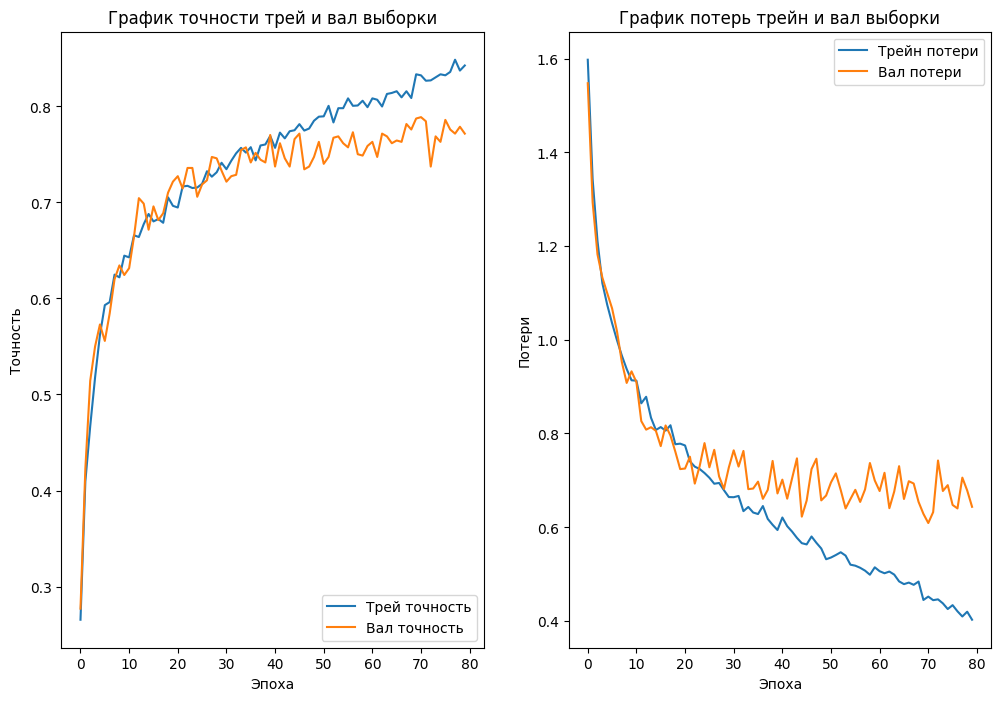

In [24]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Трей точность')
plt.plot(epochs_range, val_acc, label='Вал точность')
plt.legend(loc='lower right')
plt.title('График точности трей и вал выборки')
plt.xlabel('Эпоха')
plt.ylabel('Точность')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Трейн потери')
plt.plot(epochs_range, val_loss, label='Вал потери')
plt.legend(loc='upper right')
plt.title('График потерь трейн и вал выборки')
plt.xlabel('Эпоха')
plt.ylabel('Потери')

plt.show()


# Создайте альтернативную сверточную сеть

Дойдя до этого момента вы создали свёрточную нейронную сеть с тремя свёрточными блоками (слой свёртки + слой подвыборки) и последующим полносвязным слоем состоящим из 256 нейронов. В ячейке ниже напишите код для создания новой свёрточной сети с другой архитектурой.
В зависимости от варианта сделайте одно из изменений:


1.   Уменьшите размеры входного изображения примерно на 30%, исключите первый слой подвыборки.
2.   Уменьшите размеры входного изображения примерно на 30%, исключите второй слой подвыборки.
3.   Уменьшите размеры входного изображения примерно на 30%, исключите третий слой подвыборки.
4.   Добавьте четвертый слой свертки и подвыборки.


In [25]:
#1 вариант по списку

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(int(IMG_SHAPE * 0.7), int(IMG_SHAPE * 0.7), 3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

model.summary()

# остальной код без изменений


model.summary()

# компилирование модели
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    verbose=1
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 103, 103, 16)      448       
                                                                 
 dropout_3 (Dropout)         (None, 103, 103, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 101, 101, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 33, 33, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 33, 33, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 31, 31, 64)        18496     
                                                      

C:\Users\vita2\AppData\Local\Temp\ipykernel_7680\535873404.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/80
29/29 [==============================] - 111s 4s/step - loss: 1.5681 - accuracy: 0.2705 - val_loss: 1.5089 - val_accuracy: 0.3143
Epoch 2/80
29/29 [==============================] - 109s 4s/step - loss: 1.3908 - accuracy: 0.3608 - val_loss: 1.3152 - val_accuracy: 0.4429
Epoch 3/80
29/29 [==============================] - 109s 4s/step - loss: 1.2119 - accuracy: 0.4804 - val_loss: 1.2357 - val_accuracy: 0.4529
Epoch 4/80
29/29 [==============================] - 109s 4s/step - loss: 1.1731 - accuracy: 0.5143 - val_loss: 1.2103 - val_accuracy: 0.4900
Epoch 5/80
29/29 [==============================] - 109s 4s/step - loss: 1.1510 - accuracy: 0.5206 - val_loss: 1.1704 - val_accuracy: 0.5271
Epoch 6/80
29/29 [==============================] - 108s 4s/step - loss: 1.1155 - accuracy: 0.5386 - val_loss: 1.1558 - val_accuracy: 0.5057
Epoch 7/80
29/29 [==============================] - 110s 4s/step - loss: 1.0932 - accuracy: 0.5464 - val_loss: 1.1224 - val_accuracy: 0.5414
Epoch 8/80
29

Отобразите графики точности и потерь для новой версии сети.

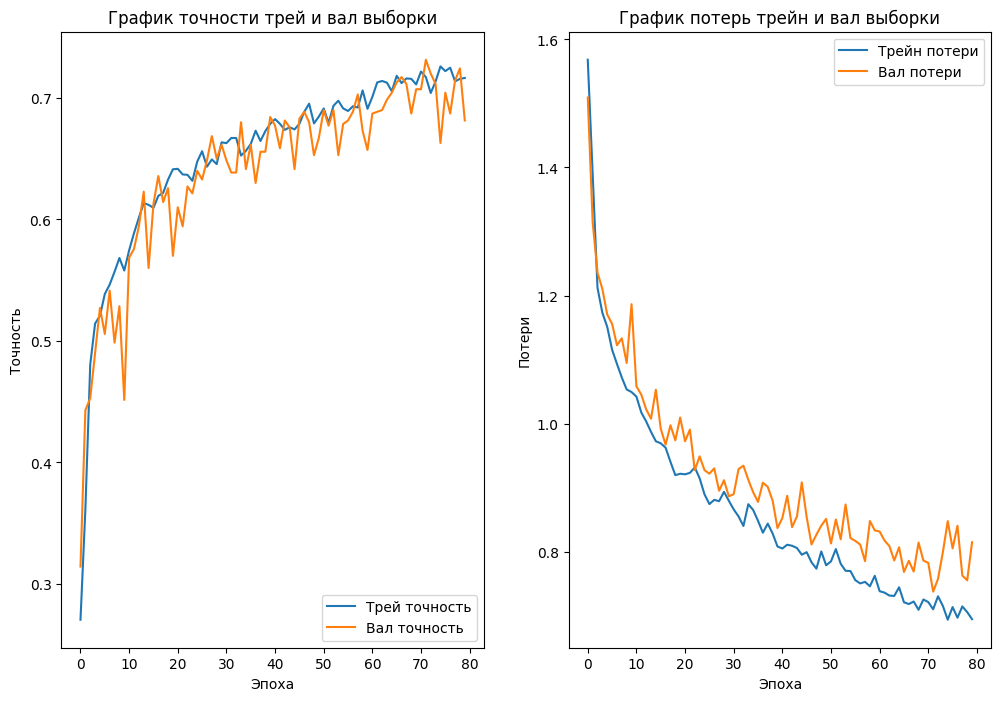

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Трей точность')
plt.plot(epochs_range, val_acc, label='Вал точность')
plt.legend(loc='lower right')
plt.title('График точности трей и вал выборки')
plt.xlabel('Эпоха')
plt.ylabel('Точность')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Трейн потери')
plt.plot(epochs_range, val_loss, label='Вал потери')
plt.legend(loc='upper right')
plt.title('График потерь трейн и вал выборки')
plt.xlabel('Эпоха')
plt.ylabel('Потери')

plt.show()

Напишите ниже выводы о качестве полученной сети по сравнению с первой:
[Писать здесь]
1. Размер входного изображения во 2 меньше поэтому могут теряться детали, в этом случае для обучения 1 сеть будет предпочтительнее
2. В 1 сети после каждого сверточного слоя есть слой подвыборки (пуллинга) поэтому вычислительная сложность будет меньше и скорость обучения выше.
3. 2 сеть по сравнению с 1 имеет меньшую точность и выше потери (видно по графику), скорее всего сказывается размер входного изображения.